# Example 1: Symbolic Regressor

In [1]:
%pylab inline
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import pydotplus

Populating the interactive namespace from numpy and matplotlib


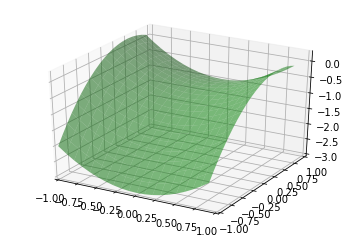

In [2]:
# Ground truth
x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1, color='green', alpha=0.5)
plt.show()

In [3]:
rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

In [4]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.578        5         0.320666         0.556764      1.14m
   1     9.97          1.70233        5         0.320202         0.624787     32.77s
   2     7.72          1.94456       11         0.239537         0.533148     28.66s
   3     5.41         0.990157        7         0.235676         0.719906     25.60s
   4     4.66         0.894443       11         0.103946         0.103946     22.83s
   5     5.41         0.940242       11         0.060802         0.060802     21.88s
   6     6.78          1.09536       11      0.000781474      0.000781474     20.50s


SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=('add', 'sub', 'mul', 'div'), generations=20,
         init_depth=(2, 6), init_method='half and half', low_memory=False,
         max_samples=0.9, metric='mean absolute error', n_jobs=1,
         p_crossover=0.7, p_hoist_mutation=0.05, p_point_mutation=0.1,
         p_point_replace=0.05, p_subtree_mutation=0.1,
         parsimony_coefficient=0.01, population_size=5000, random_state=0,
         stopping_criteria=0.01, tournament_size=20, verbose=1,
         warm_start=False)

In [5]:
print(est_gp._program)

sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))


In [6]:
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)
est_rf = RandomForestRegressor()
est_rf.fit(X_train, y_train)

/home/trev/.virtualenvs/ve3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

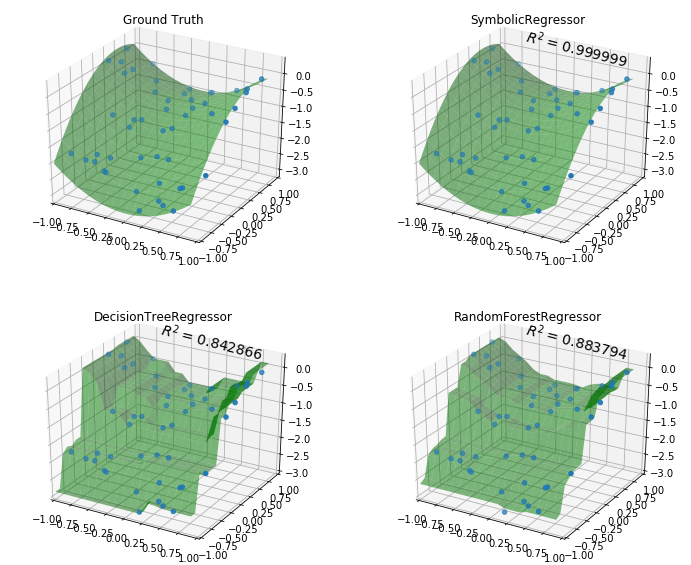

In [7]:
y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

fig = plt.figure(figsize=(12, 10))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                       (y_gp, score_gp, "SymbolicRegressor"),
                                       (y_tree, score_tree, "DecisionTreeRegressor"),
                                       (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)

plt.show()

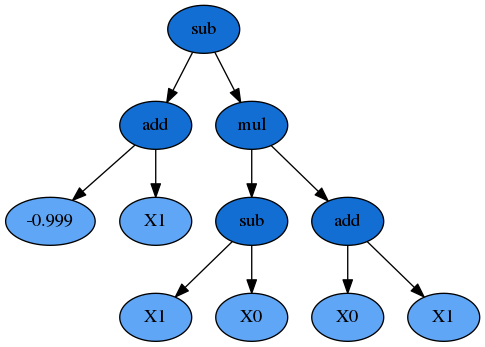

In [8]:
graph = pydotplus.graphviz.graph_from_dot_data(est_gp._program.export_graphviz())
Image(graph.create_png())

In [9]:
print(est_gp._program.parents)

{'method': 'Crossover', 'parent_idx': 1555, 'parent_nodes': range(1, 4), 'donor_idx': 78, 'donor_nodes': []}


add(-0.999, X1)
Fitness: 0.351803319075


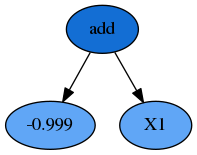

In [10]:
idx = est_gp._program.parents['donor_idx']
fade_nodes = est_gp._program.parents['donor_nodes']
print(est_gp._programs[-2][idx])
print('Fitness:', est_gp._programs[-2][idx].fitness_)
graph = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

sub(sub(X1, 0.939), mul(sub(X1, X0), add(X0, X1)))
Fitness: 0.170802040428


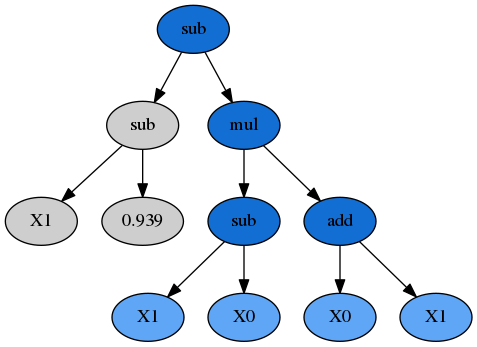

In [11]:
idx = est_gp._program.parents['parent_idx']
fade_nodes = est_gp._program.parents['parent_nodes']
print(est_gp._programs[-2][idx])
print('Fitness:', est_gp._programs[-2][idx].fitness_)
graph = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

# Example 2: Symbolic Transformer

In [12]:
from gplearn.genetic import SymbolicTransformer
from sklearn.utils import check_random_state
from sklearn.datasets import load_boston
import numpy as np

In [13]:
rng = check_random_state(0)
boston = load_boston()
perm = rng.permutation(boston.target.size)
boston.data = boston.data[perm]
boston.target = boston.target[perm]

In [14]:
from sklearn.linear_model import Ridge
est = Ridge()
est.fit(boston.data[:300, :], boston.target[:300])
print(est.score(boston.data[300:, :], boston.target[300:]))

0.75931945305


In [15]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']
gp = SymbolicTransformer(generations=20, population_size=2000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0)
gp.fit(boston.data[:300, :], boston.target[:300])

gp_features = gp.transform(boston.data)
new_boston = np.hstack((boston.data, gp_features))

est = Ridge()
est.fit(new_boston[:300, :], boston.target[:300])
print(est.score(new_boston[300:, :], boston.target[300:]))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.04         0.339876        6         0.822502         0.675124     19.34s
   1     6.91         0.593562        7         0.836993         0.602468     18.72s
   2     5.07         0.730093        8          0.84063         0.704017     19.04s
   3     5.22         0.735525        5         0.847019         0.628351     16.38s
   4     6.24         0.734679       10         0.856612         0.565138     16.82s
   5     8.23         0.721433       18          0.85677         0.728095     15.71s
   6    10.20         0.717937       14         0.875233         0.619693     14.69s
   7    11.84         0.720667       14         0.875927         0.609363     15.31s
   8    12.56         0.733019       27         0.881705         0.390121  

# Example 3: Customizing your programs

In [16]:
from gplearn.functions import make_function

In [17]:
def logic(x1, x2, x3, x4):
    return np.where(x1 > x2, x3, x4)

logical = make_function(function=logic,
                        name='logical',
                        arity=4)

In [18]:
function_set = ['add', 'sub', 'mul', 'div', logical]
gp = SymbolicTransformer(generations=2, population_size=2000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0)

In [19]:
gp.fit(boston.data[:300, :], boston.target[:300])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    55.28         0.296629        3         0.792393         0.831715      2.08s
   1    10.35         0.533096        3         0.812059         0.673758      0.00s


SymbolicTransformer(const_range=(-1.0, 1.0), feature_names=None,
          function_set=['add', 'sub', 'mul', 'div', <gplearn.functions._Function object at 0x7fcf01067a20>],
          generations=2, hall_of_fame=100, init_depth=(2, 6),
          init_method='half and half', low_memory=False, max_samples=0.9,
          metric='pearson', n_components=10, n_jobs=1, p_crossover=0.9,
          p_hoist_mutation=0.01, p_point_mutation=0.01,
          p_point_replace=0.05, p_subtree_mutation=0.01,
          parsimony_coefficient=0.0005, population_size=2000,
          random_state=0, stopping_criteria=1.0, tournament_size=20,
          verbose=1, warm_start=False)

In [20]:
print(gp._programs[0][906])

sub(logical(X6, add(X11, 0.898), X10, X2), X5)


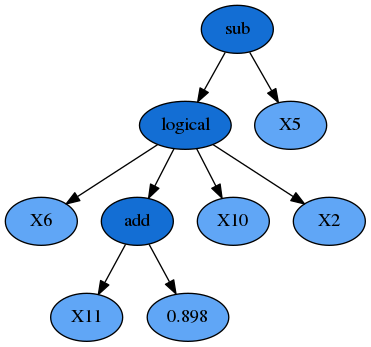

In [21]:
graph = gp._programs[0][906].export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

# Example 4: Classification

In [22]:
from gplearn.genetic import SymbolicClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer

/home/trev/.virtualenvs/ve3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/trev/.virtualenvs/ve3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/trev/.virtualenvs/ve3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


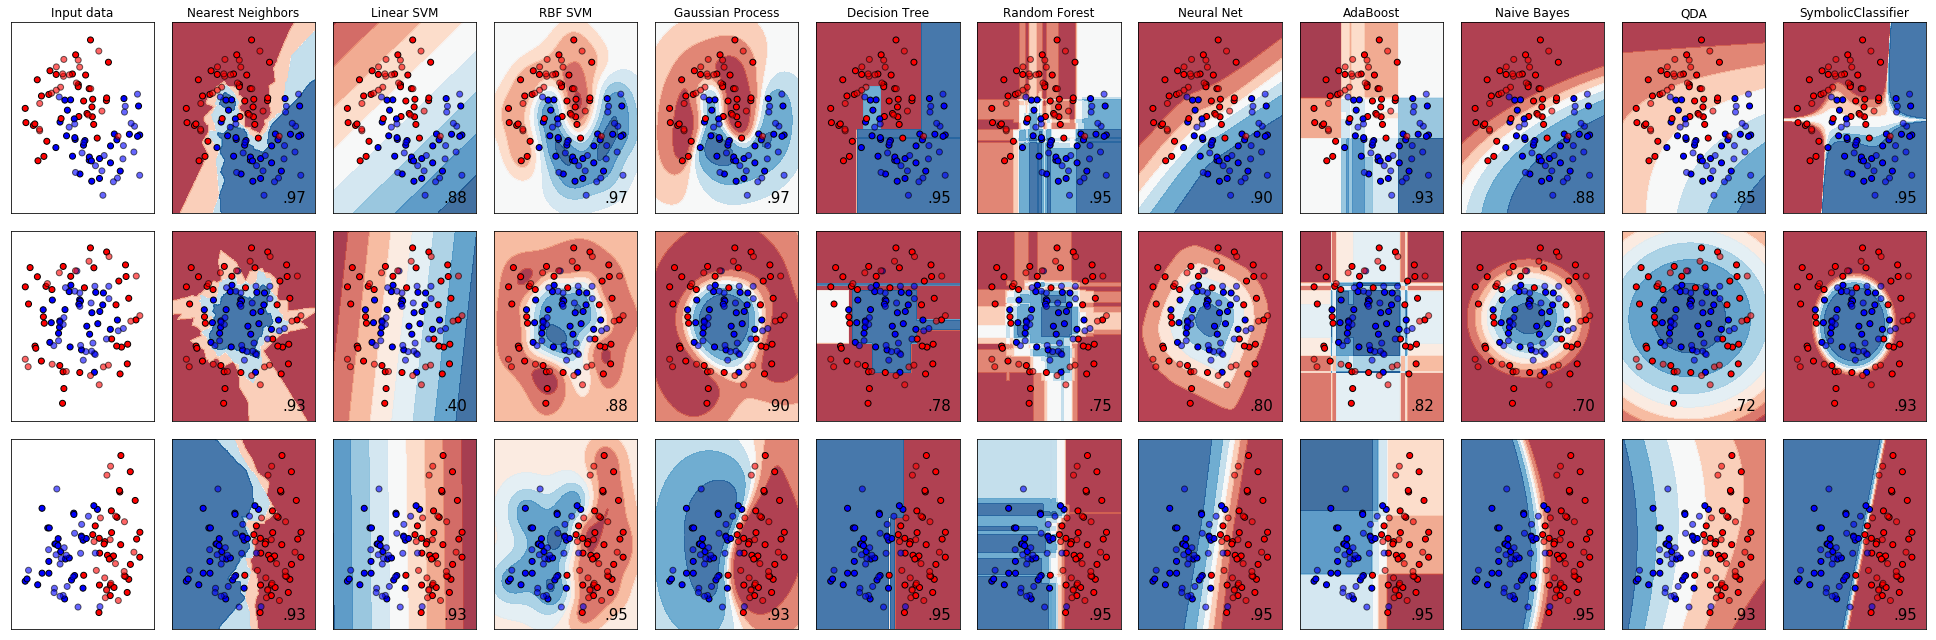

In [23]:
# Modified from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "SymbolicClassifier"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SymbolicClassifier(random_state=0)]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [24]:
rng = check_random_state(0)
cancer = load_breast_cancer()
perm = rng.permutation(cancer.target.size)
cancer.data = cancer.data[perm]
cancer.target = cancer.target[perm]

In [25]:
est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         random_state=0)
est.fit(cancer.data[:400], cancer.target[:400])

SymbolicClassifier(const_range=(-1.0, 1.0),
          feature_names=array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       ...y',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='<U23'),
          function_set=('add', 'sub', 'mul', 'div'), generations=20,
          init_depth=(2, 6), init_method='half and half', low_memory=False,
          max_samples=1.0, metric='log loss', n_jobs=1, p_crossover=0.9,
          p_hoist_mutation=0.01, p_point_mutation=0.01,
          p_point_replace=0.05, p_subtree_mutation=0.01,
          parsimony_coefficient=0.01, population_size=1000, random_state=0,
          stopping_criteria=0.0, tournament_size=20, transformer='sigmoid',
          verbose=0, warm_start=False)

In [26]:
y_true = cancer.target[400:]
y_score = est.predict_proba(cancer.data[400:])[:,1]
roc_auc_score(y_true, y_score)

0.9927514792899409

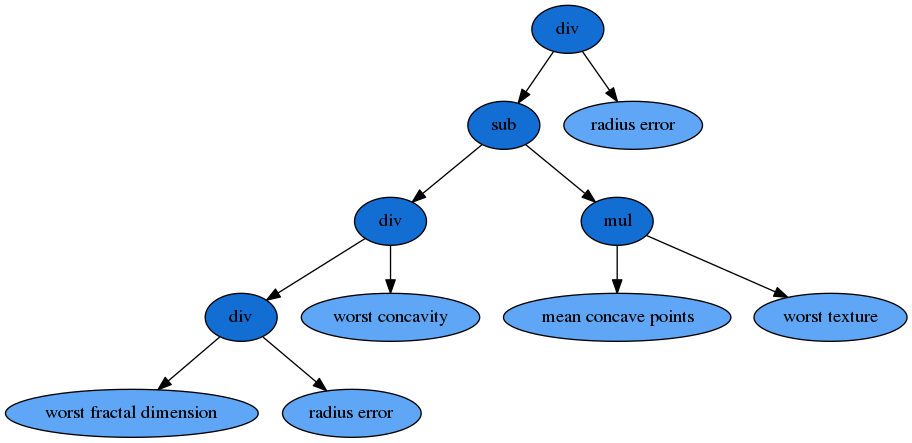

In [27]:
graph = pydotplus.graphviz.graph_from_dot_data(est._program.export_graphviz())
Image(graph.create_png())